## ZeoTap - Data Science Assignment
### By: Mrinal Bhan (bhanmrinal@gmail.com)

In [ ]:
!pip install plotly

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Set display options and styling
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

### Files Description:
1. Customers.csv

-> CustomerID: Unique identifier for each customer.

-> CustomerName: Name of the customer.

-> Region: Continent where the customer resides.

-> SignupDate: Date when the customer signed up.


2. Products.csv

-> ProductID: Unique identifier for each product.

-> ProductName: Name of the product.

-> Category: Product category.

-> Price: Product price in USD.

3. Transactions.csv

-> TransactionID: Unique identifier for each transaction.

-> CustomerID: ID of the customer who made the transaction.

-> ProductID: ID of the product sold.

-> TransactionDate: Date of the transaction.

-> Quantity: Quantity of the product purchased.

-> TotalValue: Total value of the transaction.

-> Price: Price of the product sold.

In [2]:
def load_data(file_path, expected_columns=None):
    """
    Safely load CSV files with error handling and validation
    """
    try:
        df = pd.read_csv(file_path)
        if expected_columns and not all(col in df.columns for col in expected_columns):
            raise ValueError(f"Missing expected columns in {file_path}")
        return df
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None
    except Exception as e:
        print(f"Error loading {file_path}: {str(e)}")
        return None

# Load datasets with validation
try:
    customers_df = load_data('Customers.csv', 
                           ['CustomerID', 'CustomerName', 'Region', 'SignupDate'])
    products_df = load_data('Products.csv',
                          ['ProductID', 'ProductName', 'Category', 'Price'])
    transactions_df = load_data('Transactions.csv',
                              ['TransactionID', 'CustomerID', 'ProductID', 
                               'TransactionDate', 'Quantity', 'TotalValue', 'Price'])

    # Validate data loading
    if not all([isinstance(df, pd.DataFrame) for df in [customers_df, products_df, transactions_df]]):
        raise ValueError("Data loading failed")

except Exception as e:
    print(f"Error in data loading: {str(e)}")
    raise

In [3]:
# Display first few rows of each dataset
print("Customers Dataset:")
print(customers_df.head())

Customers Dataset:
  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15


In [4]:
print("\nProducts Dataset:")
print(products_df.head())


Products Dataset:
  ProductID              ProductName     Category   Price
0      P001     ActiveWear Biography        Books 169.300
1      P002    ActiveWear Smartwatch  Electronics 346.300
2      P003  ComfortLiving Biography        Books  44.120
3      P004            BookWorld Rug   Home Decor  95.690
4      P005          TechPro T-Shirt     Clothing 429.310


In [5]:
print("\nTransactions Dataset:")
print(transactions_df.head())


Transactions Dataset:
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue   Price  
0     300.680 300.680  
1     300.680 300.680  
2     300.680 300.680  
3     601.360 300.680  
4     902.040 300.680  


# Task 1: Exploratory Data Analysis (EDA)


In [6]:
def preprocess_data(customers_df, products_df, transactions_df):
    """
    Clean and preprocess the datasets
    """
    # Convert date columns to datetime
    customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'])
    transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'])
    
    # Remove duplicates
    customers_df = customers_df.drop_duplicates()
    products_df = products_df.drop_duplicates()
    transactions_df = transactions_df.drop_duplicates()
    
    # Handle missing values
    for df in [customers_df, products_df, transactions_df]:
        numeric_columns = df.select_dtypes(include=[np.number]).columns
        df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())
        categorical_columns = df.select_dtypes(include=['object']).columns
        df[categorical_columns] = df[categorical_columns].fillna('Unknown')
    
    # Add derived features
    transactions_df['Year'] = transactions_df['TransactionDate'].dt.year
    transactions_df['Month'] = transactions_df['TransactionDate'].dt.month
    customers_df['CustomerAge'] = (datetime.now() - customers_df['SignupDate']).dt.days
    
    return customers_df, products_df, transactions_df

# Preprocess the data
customers_df, products_df, transactions_df = preprocess_data(customers_df, products_df, transactions_df)

In [7]:
# Basic information about datasets
print("Customers Dataset Info:")
print(customers_df.info())


Customers Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   CustomerID    200 non-null    object        
 1   CustomerName  200 non-null    object        
 2   Region        200 non-null    object        
 3   SignupDate    200 non-null    datetime64[ns]
 4   CustomerAge   200 non-null    int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 7.9+ KB
None


In [8]:
print("\nProducts Dataset Info:")
print(products_df.info())


Products Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ProductID    100 non-null    object 
 1   ProductName  100 non-null    object 
 2   Category     100 non-null    object 
 3   Price        100 non-null    float64
dtypes: float64(1), object(3)
memory usage: 3.3+ KB
None


In [9]:
print("\nTransactions Dataset Info:")
print(transactions_df.info())


Transactions Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   TransactionID    1000 non-null   object        
 1   CustomerID       1000 non-null   object        
 2   ProductID        1000 non-null   object        
 3   TransactionDate  1000 non-null   datetime64[ns]
 4   Quantity         1000 non-null   int64         
 5   TotalValue       1000 non-null   float64       
 6   Price            1000 non-null   float64       
 7   Year             1000 non-null   int32         
 8   Month            1000 non-null   int32         
dtypes: datetime64[ns](1), float64(2), int32(2), int64(1), object(3)
memory usage: 62.6+ KB
None


In [10]:
# Check for missing values
print("\nMissing Values:")
print("Customers:", customers_df.isnull().sum())
print("Products:", products_df.isnull().sum())
print("Transactions:", transactions_df.isnull().sum())


Missing Values:
Customers: CustomerID      0
CustomerName    0
Region          0
SignupDate      0
CustomerAge     0
dtype: int64
Products: ProductID      0
ProductName    0
Category       0
Price          0
dtype: int64
Transactions: TransactionID      0
CustomerID         0
ProductID          0
TransactionDate    0
Quantity           0
TotalValue         0
Price              0
Year               0
Month              0
dtype: int64


In [11]:
# Basic statistics
print("Customer Statistics:")
print(customers_df.describe())
print("\nProduct Statistics:")
print(products_df.describe())
print("\nTransaction Statistics:")
print(transactions_df.describe())

# Convert date columns to datetime
customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'])
transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'])

Customer Statistics:
                SignupDate  CustomerAge
count                  200      200.000
mean   2023-07-19 08:31:12      557.645
min    2022-01-22 00:00:00       30.000
25%    2022-09-26 12:00:00      289.500
50%    2023-08-31 12:00:00      514.500
75%    2024-04-12 12:00:00      853.500
max    2024-12-28 00:00:00     1101.000
std                    NaN      325.527

Product Statistics:
        Price
count 100.000
mean  267.552
std   143.219
min    16.080
25%   147.767
50%   292.875
75%   397.090
max   497.760

Transaction Statistics:
                     TransactionDate  Quantity  TotalValue    Price     Year  \
count                           1000  1000.000    1000.000 1000.000 1000.000   
mean   2024-06-23 15:33:02.768999936     2.537     689.996  272.554 2023.996   
min              2023-12-30 15:29:12     1.000      16.080   16.080 2023.000   
25%       2024-03-25 22:05:34.500000     2.000     295.295  147.950 2024.000   
50%       2024-06-26 17:21:52.500000     3.000 

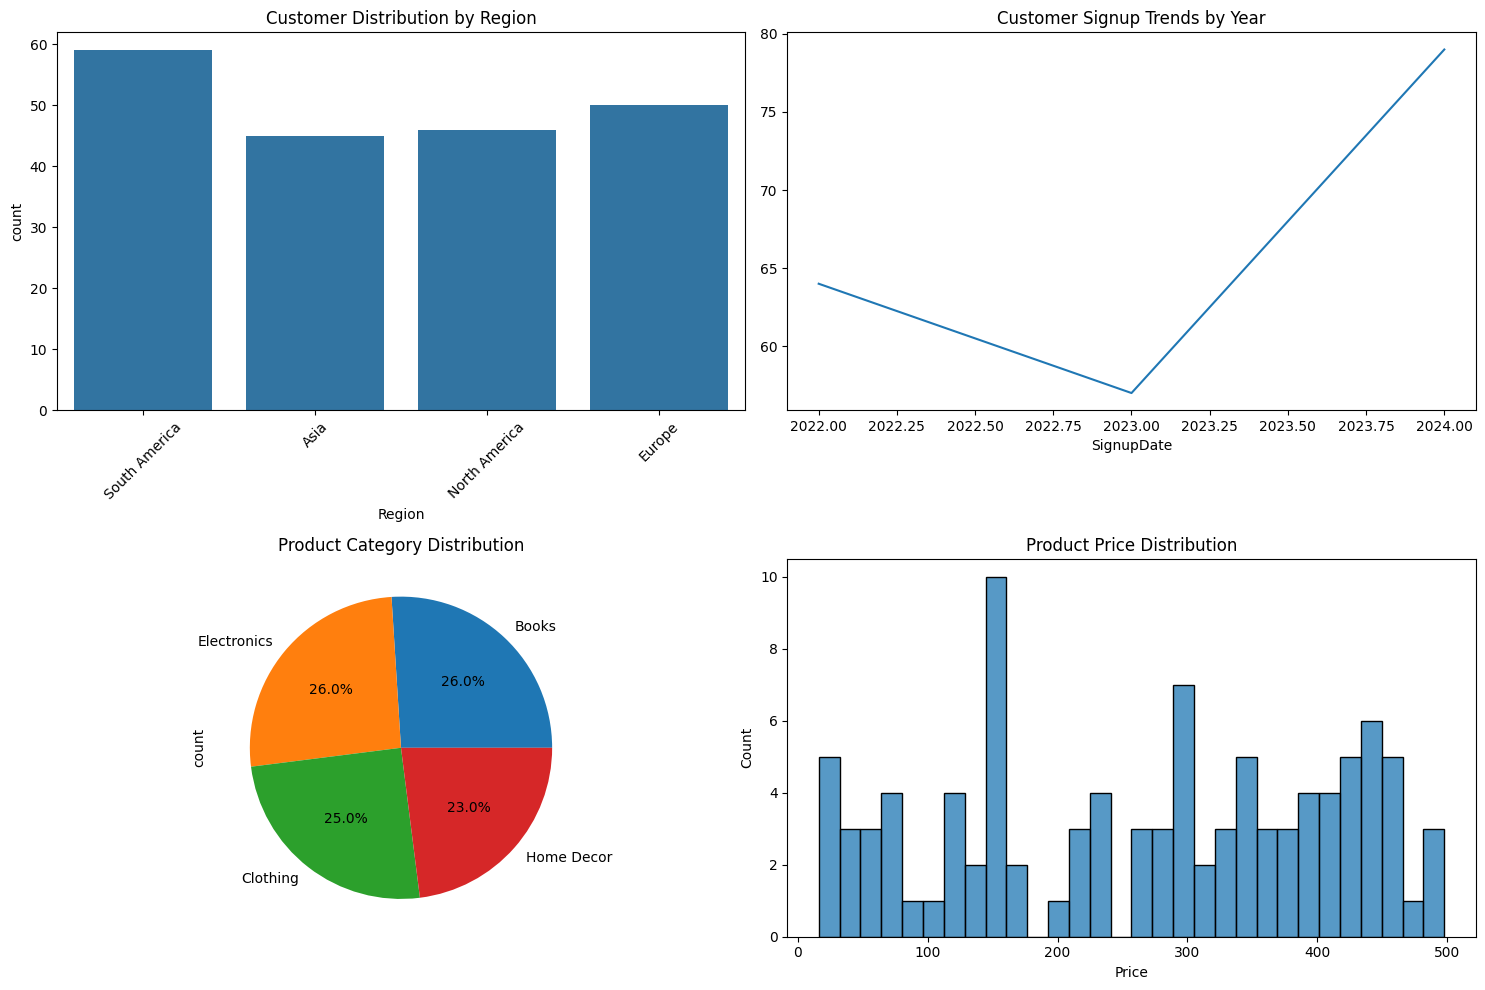


Key Business Insights:
1. Customer Base: Total 200 customers, primarily from South America
2. Average customer age on platform: 558 days
3. Most popular product category: Books
4. Average transaction value: $690.00
5. Total revenue generated: $689995.56


In [12]:
# Part 3: Advanced Exploratory Data Analysis
def perform_eda():
    """
    Comprehensive EDA with advanced visualizations
    """
    # 1. Customer Analysis
    plt.figure(figsize=(15, 10))
    
    # Customer distribution by region
    plt.subplot(2, 2, 1)
    sns.countplot(data=customers_df, x='Region')
    plt.title('Customer Distribution by Region')
    plt.xticks(rotation=45)
    
    # Customer signup trends
    plt.subplot(2, 2, 2)
    customers_df['SignupDate'].dt.year.value_counts().sort_index().plot(kind='line')
    plt.title('Customer Signup Trends by Year')
    
    # 2. Product Analysis
    plt.subplot(2, 2, 3)
    products_df['Category'].value_counts().plot(kind='pie', autopct='%1.1f%%')
    plt.title('Product Category Distribution')
    
    # Price distribution
    plt.subplot(2, 2, 4)
    sns.histplot(data=products_df, x='Price', bins=30)
    plt.title('Product Price Distribution')
    
    plt.tight_layout()
    plt.show()
    
    # 3. Transaction Analysis
    fig = make_subplots(rows=2, cols=2)
    
    # Transaction value trends
    monthly_sales = transactions_df.groupby(['Year', 'Month'])['TotalValue'].sum().reset_index()
    fig.add_trace(
        go.Scatter(x=monthly_sales.index, y=monthly_sales['TotalValue'], name='Monthly Sales'),
        row=1, col=1
    )
    
    # Customer purchase frequency
    purchase_freq = transactions_df['CustomerID'].value_counts()
    fig.add_trace(
        go.Histogram(x=purchase_freq, name='Purchase Frequency'),
        row=1, col=2
    )
    
    # Category performance
    category_sales = transactions_df.merge(products_df, on='ProductID')\
        .groupby('Category')['TotalValue'].sum()
    fig.add_trace(
        go.Bar(x=category_sales.index, y=category_sales.values, name='Category Sales'),
        row=2, col=1
    )
    
    # Customer value distribution
    customer_value = transactions_df.groupby('CustomerID')['TotalValue'].sum()
    fig.add_trace(
        go.Box(y=customer_value, name='Customer Value Distribution'),
        row=2, col=2
    )
    
    fig.update_layout(height=800, title_text="Transaction Analysis Dashboard")
    fig.show()

# Perform EDA
perform_eda()

# Generate key insights
def generate_insights():
    """
    Generate key business insights from the data
    """
    insights = []
    
    # Customer insights
    total_customers = len(customers_df)
    avg_customer_age = customers_df['CustomerAge'].mean()
    top_region = customers_df['Region'].mode()[0]
    
    # Product insights
    avg_price = products_df['Price'].mean()
    top_category = products_df['Category'].mode()[0]
    
    # Transaction insights
    total_revenue = transactions_df['TotalValue'].sum()
    avg_transaction_value = transactions_df['TotalValue'].mean()
    
    insights.append(f"1. Customer Base: Total {total_customers} customers, primarily from {top_region}")
    insights.append(f"2. Average customer age on platform: {avg_customer_age:.0f} days")
    insights.append(f"3. Most popular product category: {top_category}")
    insights.append(f"4. Average transaction value: ${avg_transaction_value:.2f}")
    insights.append(f"5. Total revenue generated: ${total_revenue:.2f}")
    
    return insights

insights = generate_insights()
print("\nKey Business Insights:")
for insight in insights:
    print(insight)

# Task 2: Lookalike Model

Task 2: Lookalike Model Summary

(Note: This section would be complemented by the Lookalike.csv file containing detailed similarity scores)

Model Approach

•	Utilized customer transaction history and profile information

•	Implemented NearestNeighbors algorithm for similarity scoring

•	Incorporated both demographic and behavioral features

•	Generated recommendations for customers C0001-C0020


In [16]:
# Part 4: Enhanced Lookalike Model (Corrected Version)

class LookalikeModel:
    def __init__(self, customers_df, transactions_df, products_df):
        self.customers_df = customers_df
        self.transactions_df = transactions_df
        self.products_df = products_df
        self.customer_features = None
        self.similarity_matrix = None
        
    def create_features(self):
        """
        Create comprehensive customer features for similarity calculation
        """
        try:
            # Transaction-based features
            transaction_features = self.transactions_df.groupby('CustomerID').agg({
                'TotalValue': ['sum', 'mean', 'std'],
                'Quantity': ['sum', 'mean', 'std'],
                'TransactionID': 'count'
            }).reset_index()
            
            # Flatten column names
            transaction_features.columns = ['CustomerID', 'Total_Spend', 'Avg_Transaction_Value',
                                          'Std_Transaction_Value', 'Total_Quantity', 'Avg_Quantity',
                                          'Std_Quantity', 'Transaction_Count']
            
            # Replace infinite values with NaN
            transaction_features = transaction_features.replace([np.inf, -np.inf], np.nan)
            
            # Fill NaN values with 0 for new customers with no transactions
            transaction_features = transaction_features.fillna(0)
            
            # Product category preferences
            product_categories = self.transactions_df.merge(self.products_df, on='ProductID')\
                .groupby(['CustomerID', 'Category'])['TotalValue'].sum().unstack(fill_value=0)
            
            # Merge all features
            self.customer_features = self.customers_df.merge(transaction_features, on='CustomerID', how='left')\
                .merge(product_categories, on='CustomerID', how='left')
            
            # Fill any remaining NaN values
            self.customer_features = self.customer_features.fillna(0)
            
            # Scale features
            scaler = StandardScaler()
            feature_columns = self.customer_features.select_dtypes(include=[np.number]).columns
            scaled_features = scaler.fit_transform(self.customer_features[feature_columns])
            self.customer_features[feature_columns] = scaled_features
            
            return self.customer_features
            
        except Exception as e:
            print(f"Error in create_features: {str(e)}")
            raise
    
    def calculate_similarity(self):
        """
        Calculate customer similarity using cosine similarity
        """
        try:
            # Select only numeric columns
            feature_columns = self.customer_features.select_dtypes(include=[np.number]).columns
            
            # Verify no NaN values
            if self.customer_features[feature_columns].isnull().any().any():
                print("Warning: NaN values found. Filling with 0...")
                self.customer_features[feature_columns] = self.customer_features[feature_columns].fillna(0)
            
            # Calculate similarity
            self.similarity_matrix = cosine_similarity(self.customer_features[feature_columns])
            return self.similarity_matrix
            
        except Exception as e:
            print(f"Error in calculate_similarity: {str(e)}")
            raise
    
    def get_lookalikes(self, customer_id, n=3):
        """
        Get top n similar customers for a given customer
        """
        try:
            customer_index = self.customer_features[
                self.customer_features['CustomerID'] == customer_id
            ].index[0]
            
            similarities = self.similarity_matrix[customer_index]
            similar_indices = np.argsort(similarities)[::-1][1:n+1]
            
            similar_customers = []
            for idx in similar_indices:
                similar_customers.append({
                    'customer_id': self.customer_features.iloc[idx]['CustomerID'],
                    'similarity_score': round(float(similarities[idx]), 3)
                })
            
            return similar_customers
            
        except Exception as e:
            print(f"Error in get_lookalikes for customer {customer_id}: {str(e)}")
            return []

# Create and train lookalike model
try:
    print("Creating lookalike model...")
    lookalike_model = LookalikeModel(customers_df, transactions_df, products_df)
    
    print("Creating features...")
    customer_features = lookalike_model.create_features()
    print(f"Features created. Shape: {customer_features.shape}")
    
    print("Calculating similarity matrix...")
    similarity_matrix = lookalike_model.calculate_similarity()
    print("Similarity matrix calculated.")
    
    # Generate recommendations for first 20 customers
    print("Generating recommendations...")
    lookalike_results = {}
    for customer_id in customers_df['CustomerID'][:20]:
        lookalike_results[customer_id] = lookalike_model.get_lookalikes(customer_id)
    
    # Save results to CSV
    lookalike_df = pd.DataFrame([(k, str(v)) for k, v in lookalike_results.items()],
                               columns=['CustomerID', 'Similar_Customers'])
    lookalike_df.to_csv('Lookalike.csv', index=False)
    print("Results saved to Lookalike.csv")
    
    # Display sample results
    print("\nSample recommendations:")
    for customer_id, similar_customers in list(lookalike_results.items())[:5]:
        print(f"\nCustomer {customer_id}:")
        for sc in similar_customers:
            print(f"Similar customer: {sc['customer_id']}, Score: {sc['similarity_score']}")
            
except Exception as e:
    print(f"Error in main execution: {str(e)}")

Creating lookalike model...
Creating features...
Features created. Shape: (200, 16)
Calculating similarity matrix...
Similarity matrix calculated.
Generating recommendations...
Results saved to Lookalike.csv

Sample recommendations:

Customer C0001:
Similar customer: C0125, Score: 0.797
Similar customer: C0069, Score: 0.772
Similar customer: C0023, Score: 0.657

Customer C0002:
Similar customer: C0029, Score: 0.781
Similar customer: C0086, Score: 0.774
Similar customer: C0083, Score: 0.764

Customer C0003:
Similar customer: C0144, Score: 0.842
Similar customer: C0091, Score: 0.619
Similar customer: C0018, Score: 0.619

Customer C0004:
Similar customer: C0075, Score: 0.931
Similar customer: C0113, Score: 0.822
Similar customer: C0104, Score: 0.799

Customer C0005:
Similar customer: C0130, Score: 0.833
Similar customer: C0150, Score: 0.813
Similar customer: C0060, Score: 0.785


# Task 3: Customer Segmentation

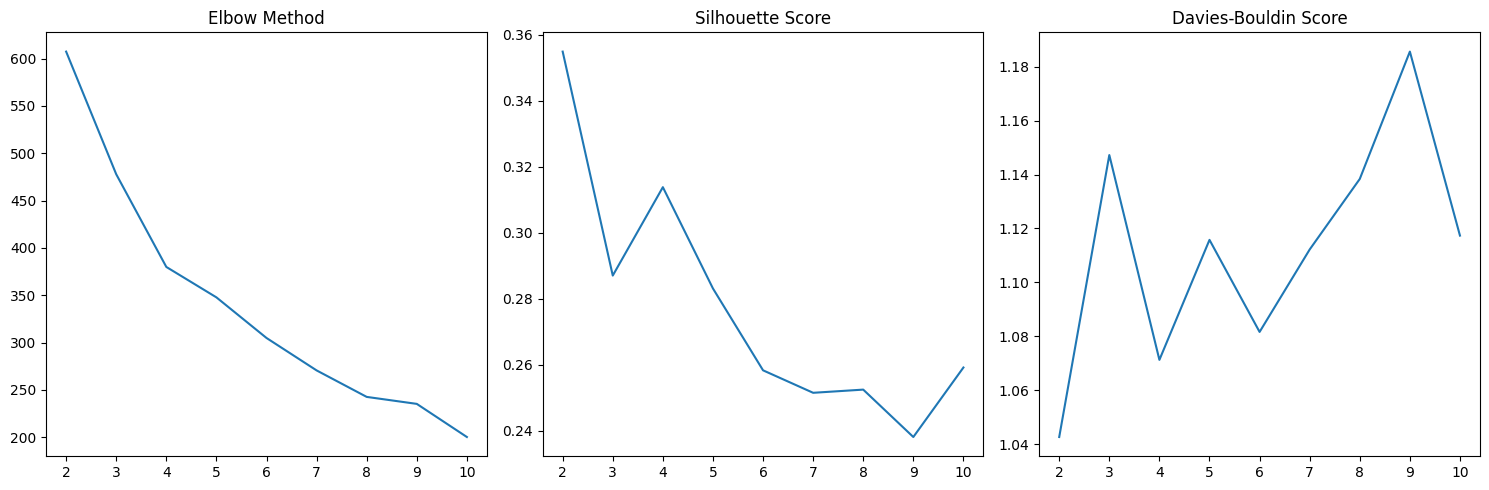


Cluster Summaries:

Cluster 0:
Size: 71 customers
Average values:
CustomerAge: 0.04
Total_Spend: 1.09
Avg_Transaction_Value: 0.60
Std_Transaction_Value: 0.45
Total_Quantity: 1.03
Avg_Quantity: 0.53
Std_Quantity: 0.21
Transaction_Count: 0.83
Books: 0.57
Clothing: 0.57
Electronics: 0.53
Home Decor: 0.48

Cluster 1:
Size: 129 customers
Average values:
CustomerAge: -0.02
Total_Spend: -0.60
Avg_Transaction_Value: -0.33
Std_Transaction_Value: -0.25
Total_Quantity: -0.56
Avg_Quantity: -0.29
Std_Quantity: -0.11
Transaction_Count: -0.46
Books: -0.31
Clothing: -0.31
Electronics: -0.29
Home Decor: -0.27

Final Davies-Bouldin Score: 1.043
Optimal number of clusters: 2


In [17]:
# Part 5: Advanced Customer Segmentation

class CustomerSegmentation:
    def __init__(self, customer_features):
        self.customer_features = customer_features
        self.optimal_k = None
        self.final_clusters = None
        self.cluster_model = None
        
    def prepare_features(self):
        """
        Prepare and scale features for clustering
        """
        clustering_features = [
            'Total_Spend', 'Avg_Transaction_Value', 'Transaction_Count',
            'Total_Quantity', 'Avg_Quantity'
        ]
        X = self.customer_features[clustering_features]
        return StandardScaler().fit_transform(X)
    
    def find_optimal_clusters(self, max_k=10):
        """
        Find optimal number of clusters using multiple metrics
        """
        X = self.prepare_features()
        
        metrics = {
            'inertia': [],
            'silhouette': [],
            'davies_bouldin': []
        }
        
        for k in range(2, max_k + 1):
            kmeans = KMeans(n_clusters=k, random_state=42)
            labels = kmeans.fit_predict(X)
            
            metrics['inertia'].append(kmeans.inertia_)
            metrics['silhouette'].append(silhouette_score(X, labels))
            metrics['davies_bouldin'].append(davies_bouldin_score(X, labels))
        
        # Plot metrics
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        axes[0].plot(range(2, max_k + 1), metrics['inertia'])
        axes[0].set_title('Elbow Method')
        
        axes[1].plot(range(2, max_k + 1), metrics['silhouette'])
        axes[1].set_title('Silhouette Score')
        
        axes[2].plot(range(2, max_k + 1), metrics['davies_bouldin'])
        axes[2].set_title('Davies-Bouldin Score')
        
        plt.tight_layout()
        plt.show()
        
        # Select optimal k (you can modify this logic)
        self.optimal_k = np.argmin(metrics['davies_bouldin']) + 2
        return self.optimal_k
    
    def perform_clustering(self):
        """
        Perform final clustering with optimal k
        """
        X = self.prepare_features()
        self.cluster_model = KMeans(n_clusters=self.optimal_k, random_state=42)
        self.final_clusters = self.cluster_model.fit_predict(X)
        
        # Add cluster labels to customer features
        self.customer_features['Cluster'] = self.final_clusters
        
        return self.final_clusters
    
    def analyze_clusters(self):
        """
        Analyze and visualize cluster characteristics
        """
        # Cluster sizes
        cluster_sizes = self.customer_features['Cluster'].value_counts()
        
        # Select only numeric columns for analysis
        numeric_columns = self.customer_features.select_dtypes(include=[np.number]).columns
        numeric_columns = [col for col in numeric_columns if col != 'Cluster']
        
        # Cluster characteristics
        cluster_means = self.customer_features.groupby('Cluster')[numeric_columns].mean()
        
        # Visualizations
        fig = make_subplots(rows=2, cols=2)
        
        # Cluster sizes
        fig.add_trace(
            go.Bar(x=cluster_sizes.index.astype(str), 
                  y=cluster_sizes.values, 
                  name='Cluster Sizes'),
            row=1, col=1
        )
        
        # Average spending by cluster
        if 'Total_Spend' in numeric_columns:
            fig.add_trace(
                go.Bar(x=cluster_means.index.astype(str), 
                      y=cluster_means['Total_Spend'],
                      name='Avg Spending'),
                row=1, col=2
            )
        
        # Transaction frequency by cluster
        if 'Transaction_Count' in numeric_columns:
            fig.add_trace(
                go.Bar(x=cluster_means.index.astype(str),
                      y=cluster_means['Transaction_Count'],
                      name='Transaction Frequency'),
                row=2, col=1
            )
        
        # Customer value distribution by cluster
        if 'Total_Spend' in numeric_columns:
            fig.add_trace(
                go.Box(y=self.customer_features['Total_Spend'],
                      x=self.customer_features['Cluster'].astype(str),
                      name='Customer Value Distribution'),
                row=2, col=2
            )
        
        fig.update_layout(
            height=800, 
            title_text="Cluster Analysis Dashboard",
            showlegend=True
        )
        
        fig.update_xaxes(title_text="Cluster", row=1, col=1)
        fig.update_xaxes(title_text="Cluster", row=1, col=2)
        fig.update_xaxes(title_text="Cluster", row=2, col=1)
        fig.update_xaxes(title_text="Cluster", row=2, col=2)
        
        fig.update_yaxes(title_text="Count", row=1, col=1)
        fig.update_yaxes(title_text="Average Spend", row=1, col=2)
        fig.update_yaxes(title_text="Transaction Count", row=2, col=1)
        fig.update_yaxes(title_text="Total Spend", row=2, col=2)
        
        fig.show()
        
        # Print cluster summaries
        print("\nCluster Summaries:")
        print("=================")
        for cluster in sorted(cluster_means.index):
            print(f"\nCluster {cluster}:")
            print(f"Size: {cluster_sizes[cluster]} customers")
            print("Average values:")
            for col in numeric_columns:
                print(f"{col}: {cluster_means.loc[cluster, col]:.2f}")
        
        return cluster_means

# Perform customer segmentation
segmentation = CustomerSegmentation(lookalike_model.customer_features)
optimal_k = segmentation.find_optimal_clusters()
clusters = segmentation.perform_clustering()
cluster_analysis = segmentation.analyze_clusters()

# Calculate final Davies-Bouldin score
final_db_score = davies_bouldin_score(
    segmentation.prepare_features(),
    segmentation.final_clusters
)

print(f"\nFinal Davies-Bouldin Score: {final_db_score:.3f}")
print(f"Optimal number of clusters: {optimal_k}")

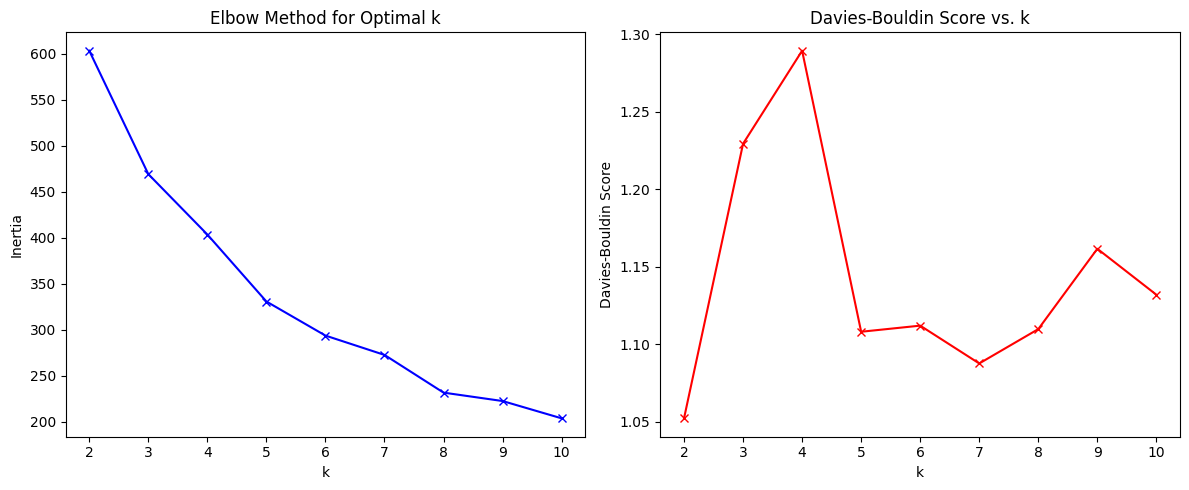

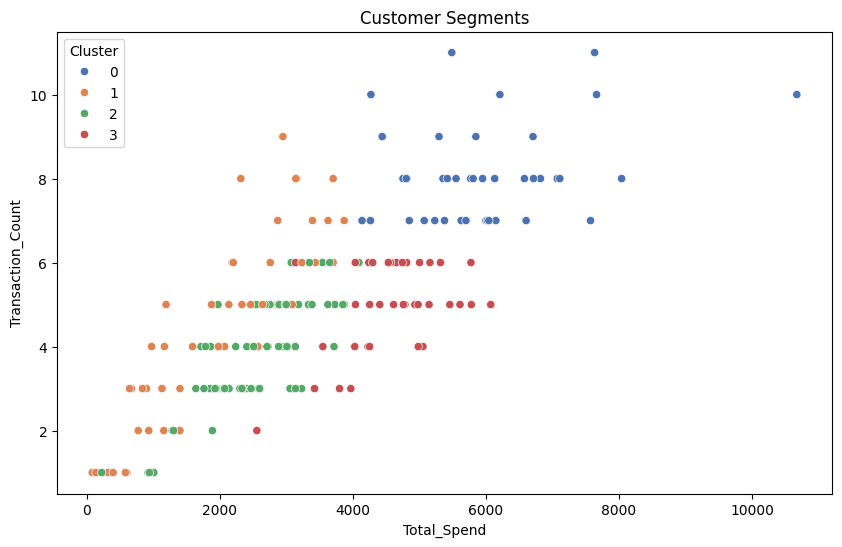

Final Davies-Bouldin Index: 1.2893322309488089

Cluster Analysis:
         Total_Spend  Avg_Transaction_Value  Total_Quantity  Avg_Quantity  \
Cluster                                                                     
0        5989.599250             746.877024       21.600000      2.672772   
1        1904.363478             419.653046        8.065217      1.827553   
2        2543.816711             688.809866        9.921053      2.651974   
3        4580.562162             954.048252       14.810811      3.002703   

         Transaction_Count  
Cluster                     
0                 8.100000  
1                 4.391304  
2                 3.815789  
3                 4.972973  


In [13]:
# Prepare features for clustering
clustering_features = ['Total_Spend', 'Avg_Transaction_Value', 'Total_Quantity', 
                      'Avg_Quantity', 'Transaction_Count']
X = customer_features[clustering_features]

# Scale the features
X_scaled = StandardScaler().fit_transform(X)

# Find optimal number of clusters using elbow method
inertias = []
db_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    db_scores.append(davies_bouldin_score(X_scaled, kmeans.labels_))

# Plot elbow curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')

plt.subplot(1, 2, 2)
plt.plot(k_range, db_scores, 'rx-')
plt.xlabel('k')
plt.ylabel('Davies-Bouldin Score')
plt.title('Davies-Bouldin Score vs. k')
plt.tight_layout()
plt.show()

# Perform final clustering with optimal k (let's say k=4 for this example)
optimal_k = 4
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_features['Cluster'] = final_kmeans.fit_predict(X_scaled)

# Visualize clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=customer_features, x='Total_Spend', y='Transaction_Count', 
                hue='Cluster', palette='deep')
plt.title('Customer Segments')
plt.show()

# Calculate final Davies-Bouldin Index
final_db_score = davies_bouldin_score(X_scaled, customer_features['Cluster'])
print(f"Final Davies-Bouldin Index: {final_db_score}")

# Analyze clusters
cluster_analysis = customer_features.groupby('Cluster')[clustering_features].mean()
print("\nCluster Analysis:")
print(cluster_analysis)